In [113]:
import numpy as np
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D



In [114]:
X = np.load('C:/Users/Revanth/final project/X.npy') # images
Y = np.load('C:/Users/Revanth/final project/Y.npy') # labels (0 = Non IDC, 1 = IDC)

In [115]:
# indices = np.arange(Y.shape[0])
# np.random.shuffle(indices)
# indices = list(indices)
# X = X[indices]
# Y = Y[indices]

In [116]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


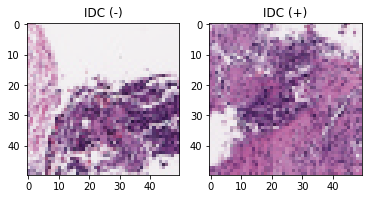

In [117]:
imgs0 = X[Y==0] # (0 = no IDC, 1 = IDC)
imgs1 = X[Y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(imgs0, imgs1) 

In [118]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=42)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)

Training Data Shape: (4437, 50, 50, 3) (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3) (1110, 50, 50, 3)


In [119]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [120]:
import warnings
warnings.filterwarnings("ignore")
num_classes=2
batch_size=128
peochs=10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',input_shape=(50,50,3),activation= 'relu', kernel_initializer='glorot_uniform',strides=1))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu', kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer = 'adam', metrics=["accuracy"])
model.summary()
history = model.fit(X_train, Y_train, validation_split=0.2,epochs= 10, batch_size= 64, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               5120128   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [121]:
from sklearn import metrics
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
prediction = model.predict(X_test, verbose=0)
prediction = (prediction > 0.5)
print(metrics.classification_report(Y_test,prediction, digits=3))

Accuracy: 75.86%
              precision    recall  f1-score   support

           0      0.724     0.850     0.782       566
           1      0.809     0.664     0.729       544

   micro avg      0.759     0.759     0.759      1110
   macro avg      0.767     0.757     0.756      1110
weighted avg      0.766     0.759     0.756      1110
 samples avg      0.759     0.759     0.759      1110



In [122]:
cnn1=model.save("cnn.h5")

Text(0, 0.5, 'accuracy')

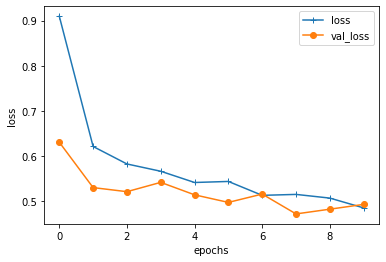

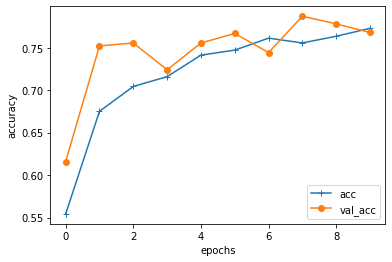

In [123]:
import pandas as pd
history_df = pd.DataFrame(history.history)
ax=history_df[['loss', 'val_loss']].plot(style=['+-','o-'])
ax.set_xlabel("epochs")
ax.set_ylabel("loss")


history_df = pd.DataFrame(history.history)
ax=history_df[['acc', 'val_acc']].plot(style=['+-','o-'])
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")



In [145]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer() 
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
explanation = explainer.explain_instance(X_test[10].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000,segmentation_fn=segmenter)

(-0.5, 49.5, 49.5, -0.5)

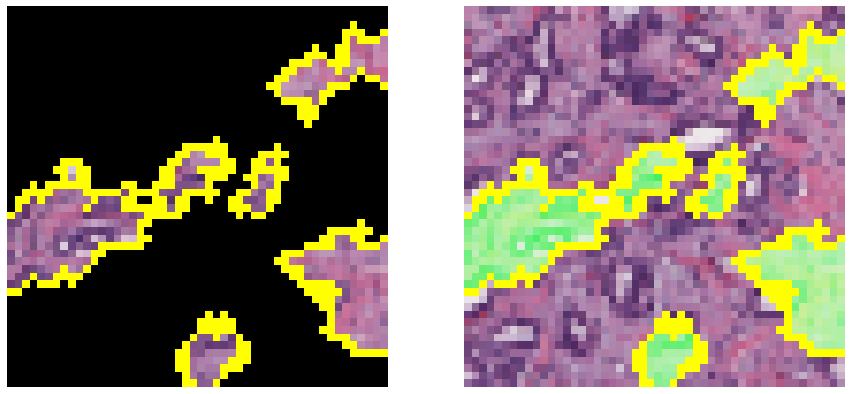

In [146]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [126]:
import shap
import numpy as np
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background,session=None, learning_phase_flags=None)
shap_values = e.shap_values(X_test[1:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


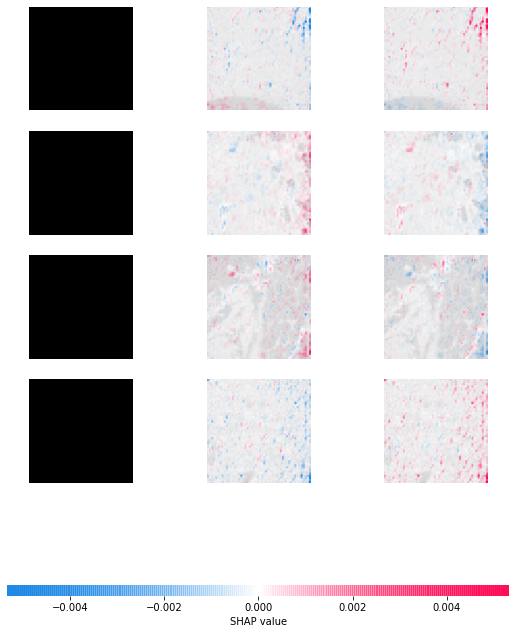

In [127]:
shap.image_plot(shap_values[:], -X_test[1:5])


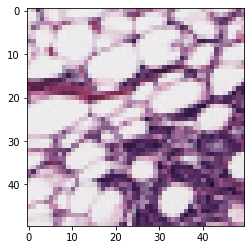

In [128]:
plt.imshow(X_test[20])

In [129]:
import matplotlib.pyplot as plt
from keras.models import load_model, Model
import numpy as np
import innvestigate.utils as iutils
import os
from keras.preprocessing.image import img_to_array, load_img

In [130]:
# Only the partial model is needed for the visualizers. Use innvestigate.utils.keras.graph.pre_softmax_tensors()
partial_model = Model(
    inputs=model.inputs,
    outputs=iutils.keras.graph.pre_softmax_tensors(model.outputs),
    name=model.name,
)
partial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9_input (InputLayer)  (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               5120128   
__________

In [131]:
#preprocess and generate Heatmap for XAI images
def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X
def heatmap(X):
    return ivis.heatmap(X)

In [132]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from numpy import save,load
from keras.preprocessing.image import img_to_array

image1_lrp = X_test[20].reshape(-1,50,50,3)
# image= image/255
# image= np.expand_dims(x, axis=0)
analyzer = innvestigate.create_analyzer('lrp.alpha_1_beta_0_IB', partial_model)
relevance  = analyzer.analyze(image1_lrp)
result_processed = postprocess(relevance)
heat_map = heatmap(result_processed)
lrp_maps1=heat_map[0]
lrp_rel1=relevance[0]

# save(path1_write,maps)
# save(path2_write,rel)

In [133]:
image1_DT = X_test[20].reshape(-1,50,50,3)
analyzer = innvestigate.create_analyzer('deep_taylor', partial_model)
relevance  = analyzer.analyze(image1_DT)
result_processed = postprocess(relevance)
heat_map = heatmap(result_processed)
DT_maps1=heat_map[0]
DT_rel1=relevance[0]

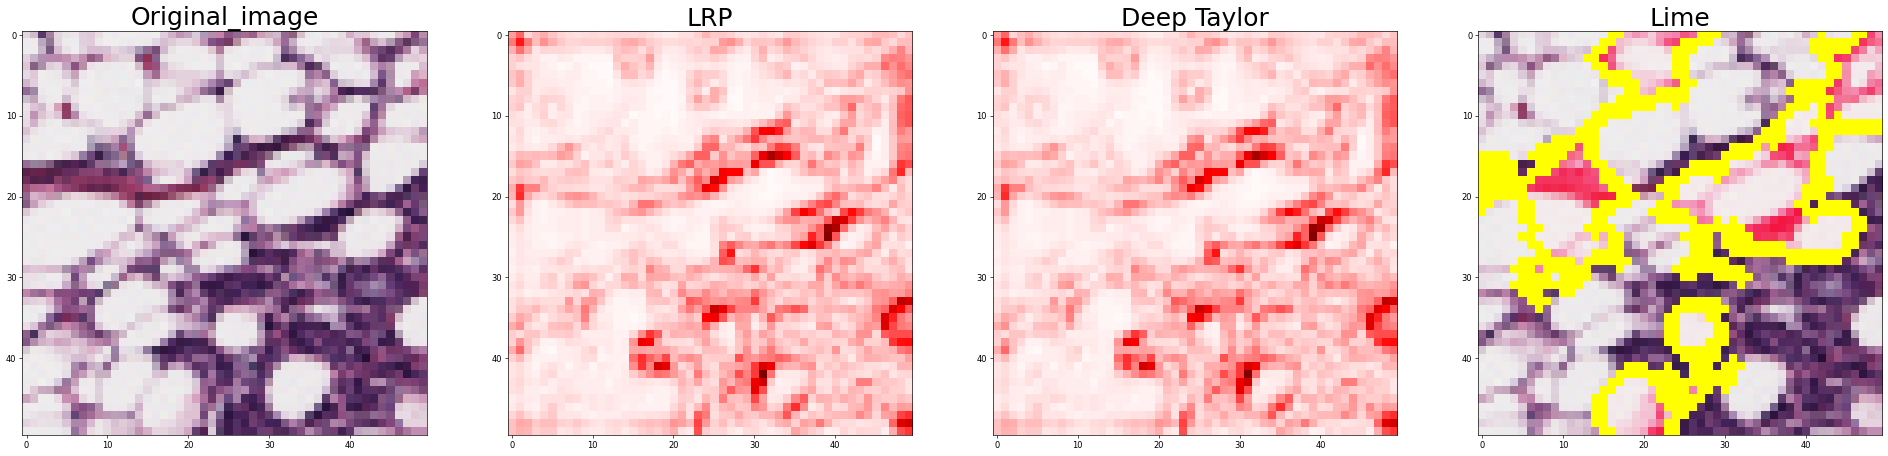

In [134]:
fig = plt.figure(figsize=(40, 40), dpi = 60)
axs = fig.subplots(1, 4)
axs[0].set_title('Original_image',fontsize=30)
axs[0].imshow(X_test[20])
axs[1].set_title('LRP',fontsize=30)
axs[1].imshow(lrp_maps1)
axs[2].set_title('Deep Taylor',fontsize=30)
axs[2].imshow(DT_maps1)
axs[3].set_title('Lime',fontsize=30)
axs[3].imshow(mark_boundaries(temp_2, mask_2))


In [135]:
import skimage.measure 

##getting lime entropy
Entropy_Deeptaylor = []
for i in range(0,20):
    img_DT= X_test[i].reshape(-1,50,50,3)
    analyzer = innvestigate.create_analyzer('deep_taylor', partial_model)
    relevance  = analyzer.analyze(img_DT)
    result_processed = postprocess(relevance)
    heat_map = heatmap(result_processed)
    entropy_Deeptaylor = skimage.measure.shannon_entropy(heat_map)
    Entropy_Deeptaylor.append(entropy_Deeptaylor) 

In [136]:
Entropy_Deeptaylor 

[4.001686406216546,
 3.827054606013246,
 3.262306363018918,
 3.7341577777783064,
 4.376462832788562,
 3.454838277514175,
 3.600825912653077,
 3.6478943576411003,
 3.2855729676161727,
 3.658080845414305,
 3.92183728290456,
 4.2921866716572135,
 3.8633038577564967,
 3.5510512840024635,
 3.4409231620017438,
 3.9276942969796425,
 3.388557559625696,
 4.253228218961355,
 3.148080784711781,
 4.527751902892062]

In [137]:
Entropy_LRP = []
for i in range(0,20):
    img_lrp = X_test[i].reshape(-1,50,50,3)
    analyzer = innvestigate.create_analyzer('lrp.alpha_1_beta_0_IB', partial_model)
    relevance  = analyzer.analyze(img_lrp)
    result_processed = postprocess(relevance)
    heat_map = heatmap(result_processed)
    entropy_Deeptaylor = skimage.measure.shannon_entropy(heat_map)
    entropy = skimage.measure.shannon_entropy(img_lrp)
    Entropy_LRP.append(entropy)    

In [138]:
Entropy_LRP

[7.211383902103778,
 6.900001405364272,
 6.859989420869559,
 6.659153340511407,
 6.921437394644498,
 4.261841075400025,
 7.660363223769716,
 4.57258862284233,
 6.235498239474839,
 6.294470823289826,
 7.187484217344243,
 7.048771981778456,
 5.8408270699294755,
 7.107891455057419,
 7.07630718360098,
 6.110367632216162,
 6.303753865576954,
 7.115535746735773,
 6.155186521421983,
 7.213709452512275]

In [139]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer() 
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
Entropy_Lime = []
for i in range(0,20):
    explanation = explainer.explain_instance(X_test[i].astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000,segmentation_fn=segmenter)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    entropy = skimage.measure.shannon_entropy(mark_boundaries(temp_2, mask_2))
    Entropy_Lime.append(entropy)    



In [140]:
Entropy_Lime

[6.236575165650203,
 6.5252921520625495,
 6.344288860795931,
 6.005843846592104,
 6.4140730065635365,
 4.020006754430519,
 6.559430402391643,
 4.446687240675923,
 5.803118454267099,
 5.71221684640575,
 6.761353188988911,
 6.344812438539839,
 5.546778138439108,
 6.326046829046431,
 6.388140367632424,
 5.772162553738214,
 5.3919914551963055,
 6.651376307821547,
 5.855207526297174,
 6.575643363378735]

In [141]:
all_Data1 = [Entropy_Lime,Entropy_LRP,Entropy_Deeptaylor ]
# data1 = pd.DataFrame(all_Data1)
labels = ['LIME','LRP','DT']

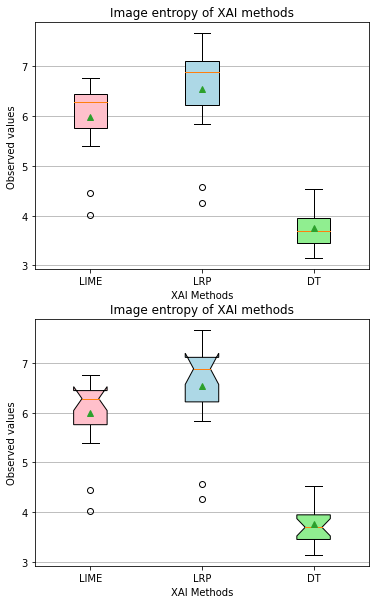

In [142]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,10))

# rectangular box plot
bplot1 = ax1.boxplot(all_Data1,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showmeans = True,
                     labels=labels)  # will be used to label x-ticks
ax1.set_title('Image entropy of XAI methods')




# notch shape box plot
bplot2 = ax2.boxplot(all_Data1,
                     notch=True,  # notch shape
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     showmeans = True,
                     labels=labels)  # will be used to label x-ticks
ax2.set_title('Image entropy of XAI methods')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('XAI Methods')
    ax.set_ylabel('Observed values')
    

plt.show()